# High Dimensional Weighted Gene Correlation Network Analysis (hdWGCNA)

**Authorship:**
Adam Klie, *08/24/2022*
***
**Description:**
Notebook to run a WGCNA on stimulated pancreatic islet multiome data (well just the RNA)
***

In [1]:
# single-cell analysis package
library(Seurat)

# plotting and data science packages
library(tidyverse)
library(cowplot)
library(patchwork)

# co-expression network analysis packages:
library(WGCNA)
library(hdWGCNA)

# gene enrichment packages
library(enrichR)
library(GeneOverlap)

# using the cowplot theme for ggplot
theme_set(theme_cowplot())

# set random seed for reproducibility
set.seed(12345)

Attaching SeuratObject

Attaching sp

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots


Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust





Attaching package: ‘WGCNA’


The following object is masked from ‘package:stats’:

    cor


Welcome to enrichR
Checking connection ... 

Enrichr ... 
Connection is Live!

FlyEnrichr ... 
Connection is available!

WormEnrichr ... 
Connection is available!

YeastEnrichr ... 
Connec

In [2]:
# Parameters
CELL.TYPES <- "beta"
ASSAY <- "RNA"
NORMALIZATION <- "ND"
NN <- 25
GENES <- "all"

In [3]:
# File names for saving
NAME=paste0(CELL.TYPES, "cells_", GENES, "genes_", NORMALIZATION, "_", NN, "neighbors")
OUT= file.path("./gene_set_enrichment", NAME)
OUT

[1] "./gene_set_enrichment/betacells_allgenes_ND_25neighbors"

In [4]:
# load the preprocessed RDS from 1_network_construction.ipynb
seurat_obj <- readRDS(sprintf('network_construction/%s_hdWGCNA.rds', NAME))

In [5]:
# enrichr databases to test
dbs <- c('GO_Biological_Process_2021','GO_Cellular_Component_2021','GO_Molecular_Function_2021',
         'Diabetes_Perturbations_GEO_2022', 'KEGG_2021_Human', 'MSigDB_Hallmark_2020')

# perform enrichment tests
seurat_obj <- RunEnrichr(
  seurat_obj,
  dbs=dbs, # character vector of enrichr databases to test
  max_genes = 100 # number of genes per module to test
)

# retrieve the output table
enrich_df <- GetEnrichrTable(seurat_obj)

Selecting by kME_betacells_allgenes_ND_25neighbors-M1


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
  Querying GO_Cellular_Component_2021... Done.
  Querying GO_Molecular_Function_2021... Done.
  Querying Diabetes_Perturbations_GEO_2022... Done.
  Querying KEGG_2021_Human... Done.
  Querying MSigDB_Hallmark_2020... Done.
Parsing results... Done.


Selecting by kME_betacells_allgenes_ND_25neighbors-M2


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
  Querying GO_Cellular_Component_2021... Done.
  Querying GO_Molecular_Function_2021... Done.
  Querying Diabetes_Perturbations_GEO_2022... Done.
  Querying KEGG_2021_Human... Done.
  Querying MSigDB_Hallmark_2020... Done.
Parsing results... Done.


Selecting by kME_betacells_allgenes_ND_25neighbors-M3


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
  Querying GO_Cellular_Component_2021... Done.
  Querying GO_Molecular_Function_2021... Done.
  Querying Diabetes_Perturbations_GEO_2022... Done.
  Querying KEGG_2021_Human... Done.
  Querying MSigDB_Hallmark_2020... Done.
Parsing results... Done.


Selecting by kME_betacells_allgenes_ND_25neighbors-M4


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
  Querying GO_Cellular_Component_2021... Done.
  Querying GO_Molecular_Function_2021... Done.
  Querying Diabetes_Perturbations_GEO_2022... Done.
  Querying KEGG_2021_Human... Done.
  Querying MSigDB_Hallmark_2020... Done.
Parsing results... Done.


Selecting by kME_betacells_allgenes_ND_25neighbors-M5


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
  Querying GO_Cellular_Component_2021... Done.
  Querying GO_Molecular_Function_2021... Done.
  Querying Diabetes_Perturbations_GEO_2022... Done.
  Querying KEGG_2021_Human... Done.
  Querying MSigDB_Hallmark_2020... Done.
Parsing results... Done.


In [6]:
# Save the module assignment table
write.table(enrich_df, sprintf("%s_enirhcR_res.tsv", OUT), sep="\t")

In [9]:
EnrichrBarPlot <- function(
  seurat_obj, outdir = "enrichr_plots",
  n_terms = 25, plot_size = c(6,15),
  logscale=FALSE, wgcna_name=NULL,  ...
){

  # get data from active assay if wgcna_name is not given
  if(is.null(wgcna_name)){wgcna_name <- seurat_obj@misc$active_wgcna}

  # get modules:
  modules <- GetModules(seurat_obj, wgcna_name)
  mods <- levels(modules$module)
  mods <- mods[mods != 'grey']

  # get Enrichr table
  enrichr_df <- GetEnrichrTable(seurat_obj, wgcna_name)

  # helper function to wrap text
  wrapText <- function(x, len) {
      sapply(x, function(y) paste(strwrap(y, len), collapse = "\n"), USE.NAMES = FALSE)
  }

  # make output dir if it doesn't exist:
  if(!dir.exists(outdir)){dir.create(outdir)}

  # loop through modules:
  for(i in 1:length(mods)){

    cur_mod <- mods[i]
    cur_terms <- subset(enrichr_df, module == cur_mod)
    print(cur_mod)

    # get color for this module:
    cur_color <- modules %>% subset(module == cur_mod) %>% .$color %>% unique %>% as.character

    # skip if there are not any terms for this module:
    if(nrow(cur_terms) == 0){next}
    cur_terms$wrap <- wrapText(cur_terms$Term, 45)

    # plot top n_terms as barplot
    plot_list <- list()
    for(cur_db in dbs){

      plot_df <- subset(cur_terms, db==cur_db) %>% top_n(n_terms, wt=Combined.Score)

      # text color:
      if(cur_mod == 'black'){
        text_color = 'grey'
      } else {
        text_color = 'black'
      }

      # logscale?
      if(logscale){
        plot_df$Combined.Score <- log(plot_df$Combined.Score)
        lab <- 'Enrichment log(combined score)'
        x <- 0.2
      } else{lab <- 'Enrichment (combined score)'; x <- 5}

      # make bar plot:
      plot_list[[cur_db]] <- ggplot(plot_df, aes(x=Combined.Score, y=reorder(wrap, Combined.Score)))+
        geom_bar(stat='identity', position='identity', color='white', fill=cur_color) +
        geom_text(aes(label=wrap), x=x, color=text_color, size=5, hjust='left') +
        ylab('Term') + xlab(lab) + ggtitle(cur_db) +
        theme(
          panel.grid.major=element_blank(),
          panel.grid.minor=element_blank(),
          legend.title = element_blank(),
          axis.ticks.y=element_blank(),
          axis.text.y=element_blank(),
          plot.title = element_text(hjust = 0.5)
        )
    }

    # make pdfs in output dir
    pdf(paste0(outdir, '/', cur_mod, '.pdf'), width=plot_size[1], height=plot_size[2])
    for(plot in plot_list){
      print(plot)
    }
    dev.off()
  }
}

In [10]:
# make GO term plots:
EnrichrBarPlot(
  seurat_obj,
  outdir = "gene_set_enrichment", # name of output directory
  n_terms = 10, # number of enriched terms to show (sometimes more show if there are ties!!!)
  plot_size = c(6,15), # width, height of the output .pdfs
  logscale=TRUE # do you want to show the enrichment as a log scale?
)

[1] "betacells_allgenes_ND_25neighbors-M1"
[1] "betacells_allgenes_ND_25neighbors-M2"
[1] "betacells_allgenes_ND_25neighbors-M3"
[1] "betacells_allgenes_ND_25neighbors-M4"
[1] "betacells_allgenes_ND_25neighbors-M5"


In [8]:
# enrichr dotplot
options(repr.plot.width=12, repr.plot.height=24)
png(sprintf("%s_GO_Biological_Process_2021_DotPlot.png", OUT), widt=1000, height=1600)
EnrichrDotPlot(
  seurat_obj,
  mods = "all", # use all modules (this is the default behavior)
  database = "GO_Biological_Process_2021", # this has to be one of the lists we used above!!!
  n_terms=5 # number of terms for each module
)
dev.off()

png 
  2

In [9]:
# enrichr dotplot
options(repr.plot.width=12, repr.plot.height=24)
png(sprintf("%s_GO_Cellular_Component_2021_DotPlot.png", OUT), widt=1000, height=1600)
EnrichrDotPlot(
  seurat_obj,
  mods = "all", # use all modules (this is the default behavior)
  database = "GO_Cellular_Component_2021", # this has to be one of the lists we used above!!!
  n_terms=5 # number of terms for each module
)
dev.off()

png 
  2

In [10]:
# enrichr dotplot
options(repr.plot.width=12, repr.plot.height=24)
png(sprintf("%s_GO_Molecular_Function_2021_DotPlot.png", OUT), widt=1000, height=1600)
EnrichrDotPlot(
  seurat_obj,
  mods = "all", # use all modules (this is the default behavior)
  database = "GO_Molecular_Function_2021", # this has to be one of the lists we used above!!!
  n_terms=5 # number of terms for each module
)
dev.off()

png 
  2

In [11]:
# enrichr dotplot
options(repr.plot.width=12, repr.plot.height=24)
png(sprintf("%s_Diabetes_Perturbations_GEO_2022.png", OUT), widt=1000, height=1600)
EnrichrDotPlot(
  seurat_obj,
  mods = "all", # use all modules (this is the default behavior)
  database = "Diabetes_Perturbations_GEO_2022", # this has to be one of the lists we used above!!!
  n_terms=5 # number of terms for each module
)
dev.off()

png 
  2

In [12]:
# enrichr dotplot
options(repr.plot.width=12, repr.plot.height=24)
png(sprintf("%s_KEGG_2021_Human.png", OUT), widt=1000, height=1600)
EnrichrDotPlot(
  seurat_obj,
  mods = "all", # use all modules (this is the default behavior)
  database = "KEGG_2021_Human", # this has to be one of the lists we used above!!!
  n_terms=5 # number of terms for each module
)
dev.off()

png 
  2

In [13]:
# enrichr dotplot
options(repr.plot.width=12, repr.plot.height=24)
png(sprintf("%s_MSigDB_Hallmark_2020.png", OUT), widt=1000, height=1600)
EnrichrDotPlot(
  seurat_obj,
  mods = "all", # use all modules (this is the default behavior)
  database = "MSigDB_Hallmark_2020", # this has to be one of the lists we used above!!!
  n_terms=5 # number of terms for each module
)
dev.off()

png 
  2

# Sandbox

In [32]:
# compute cell-type marker genes with Seurat:
Idents(seurat_obj) <- seurat_obj$cell.type
markers <- Seurat::FindAllMarkers(
  seurat_obj,
  assay="RNA",
  slot="data",
  only.pos = TRUE,
  logfc.threshold=1
)

# compute marker gene overlaps
overlap_df <- OverlapModulesDEGs(
  seurat_obj,
  deg_df = markers,
  fc_cutoff = 1 # log fold change cutoff for overlap analysis
)

Calculating cluster Alpha

Calculating cluster Beta.UPRlo

Calculating cluster Beta.UPRhi

Calculating cluster Delta



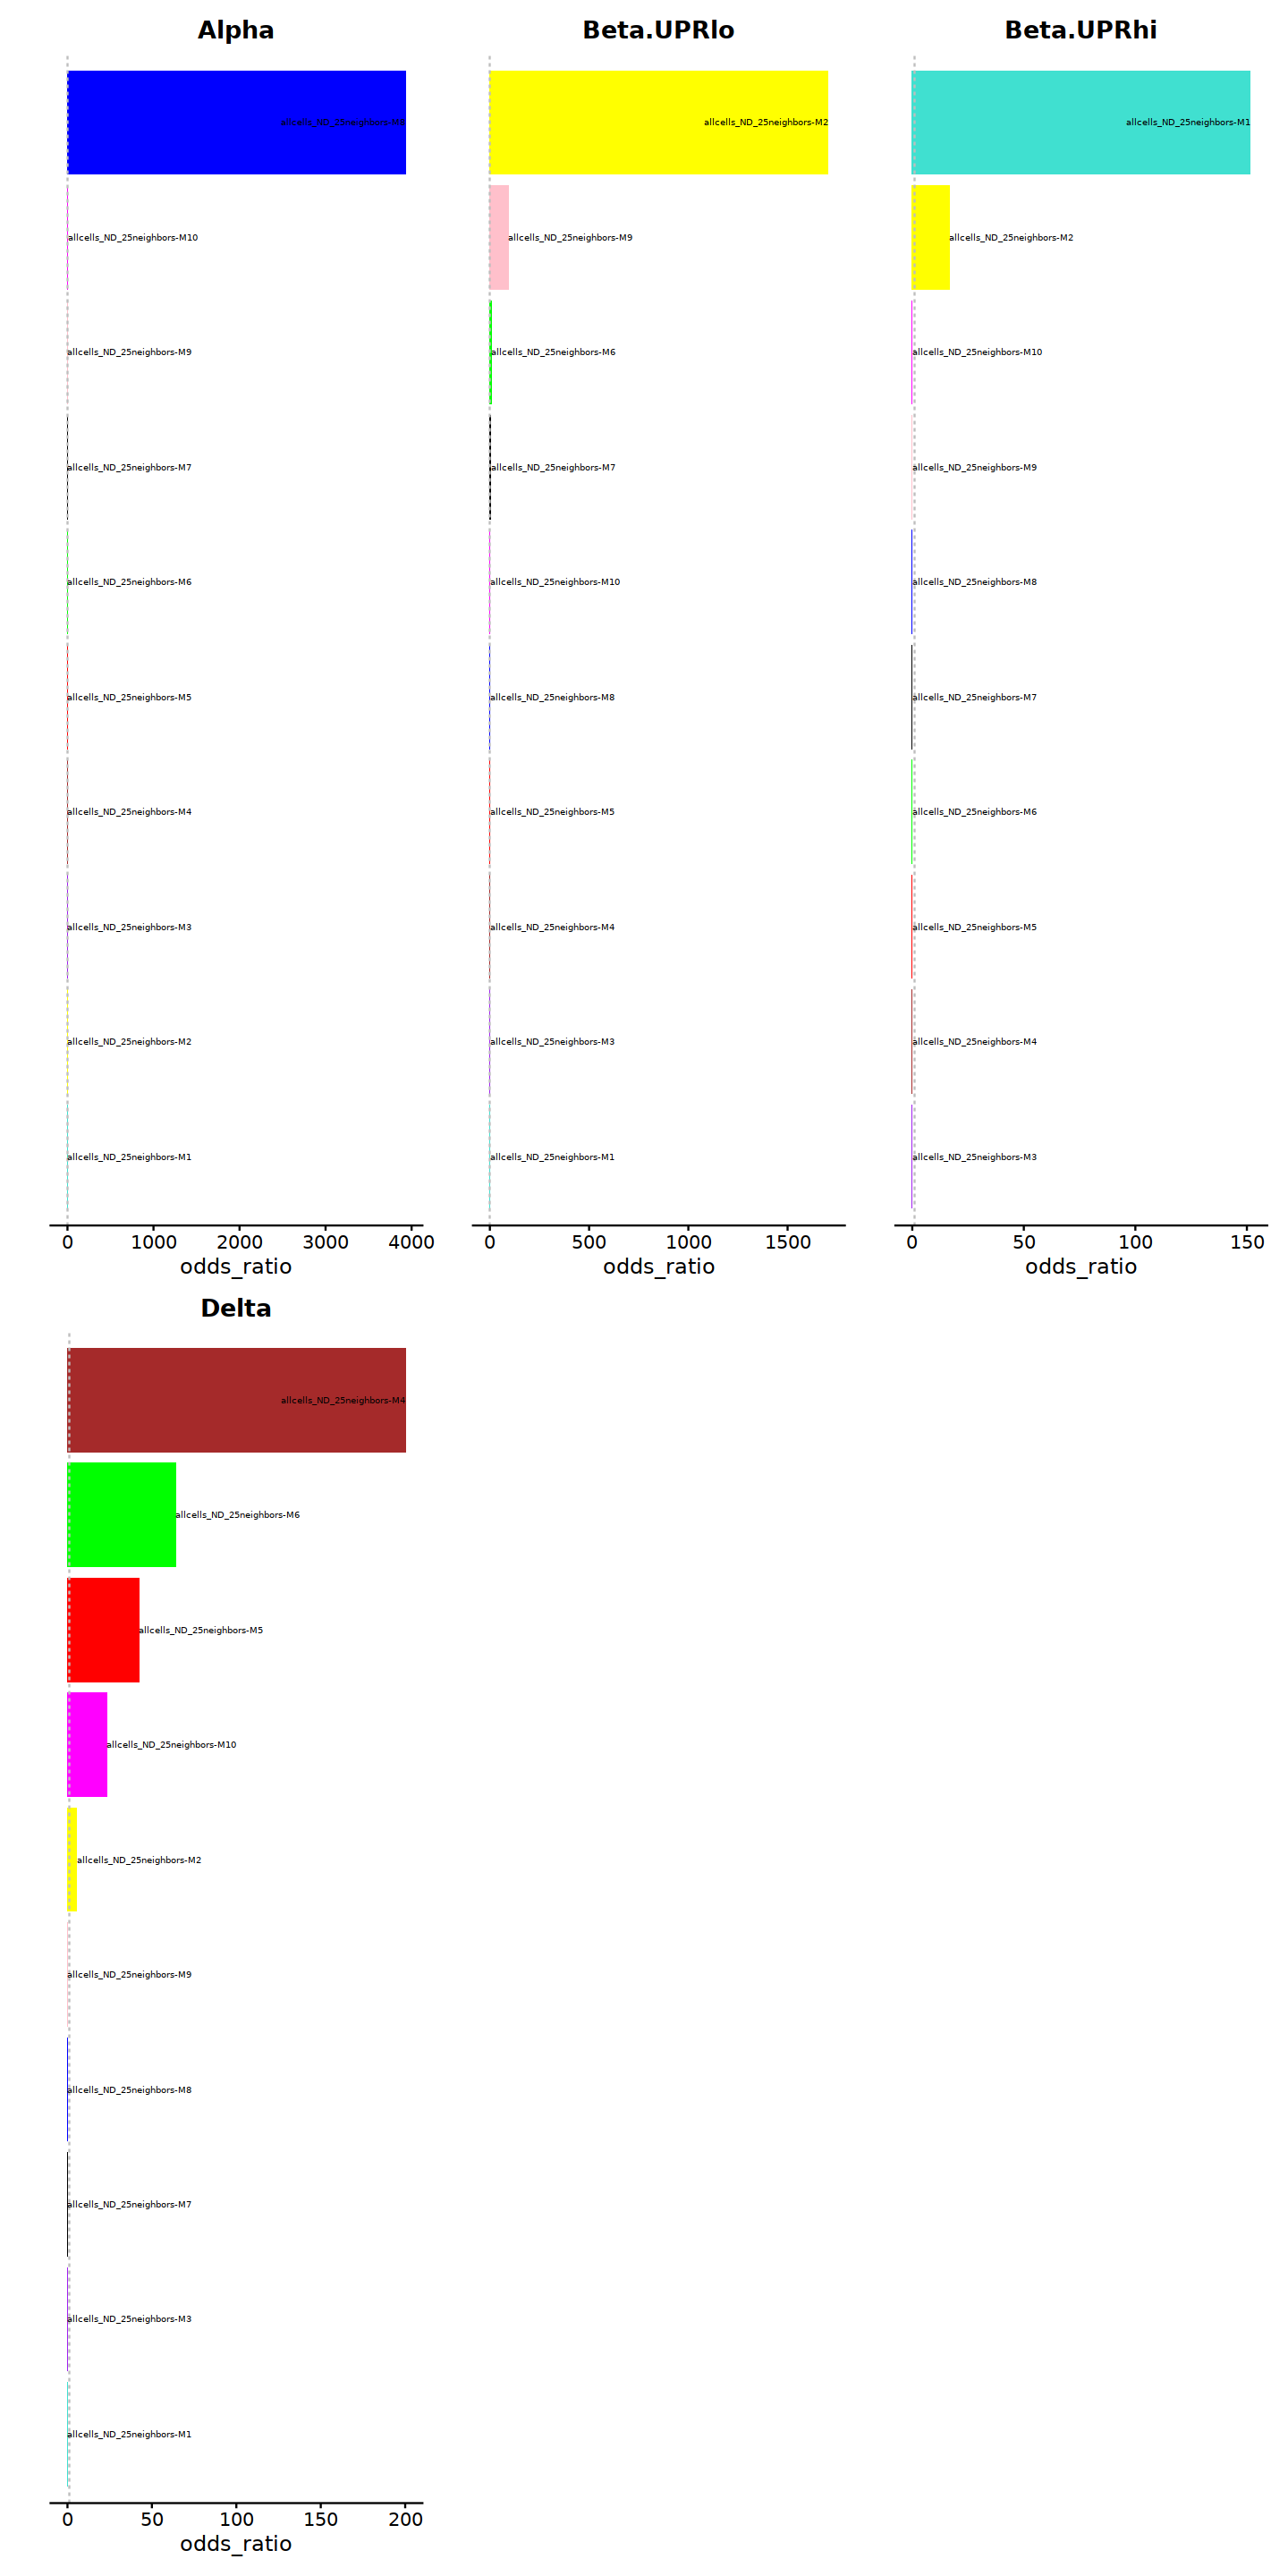

In [33]:
# overlap barplot, produces a plot for each cell type
plot_list <- OverlapBarPlot(overlap_df)

# stitch plots with patchwork
wrap_plots(plot_list, ncol=3)

Warning message in sqrt(x):
“NaNs produced”
Warning message:
“Removed 27 rows containing missing values (geom_point).”


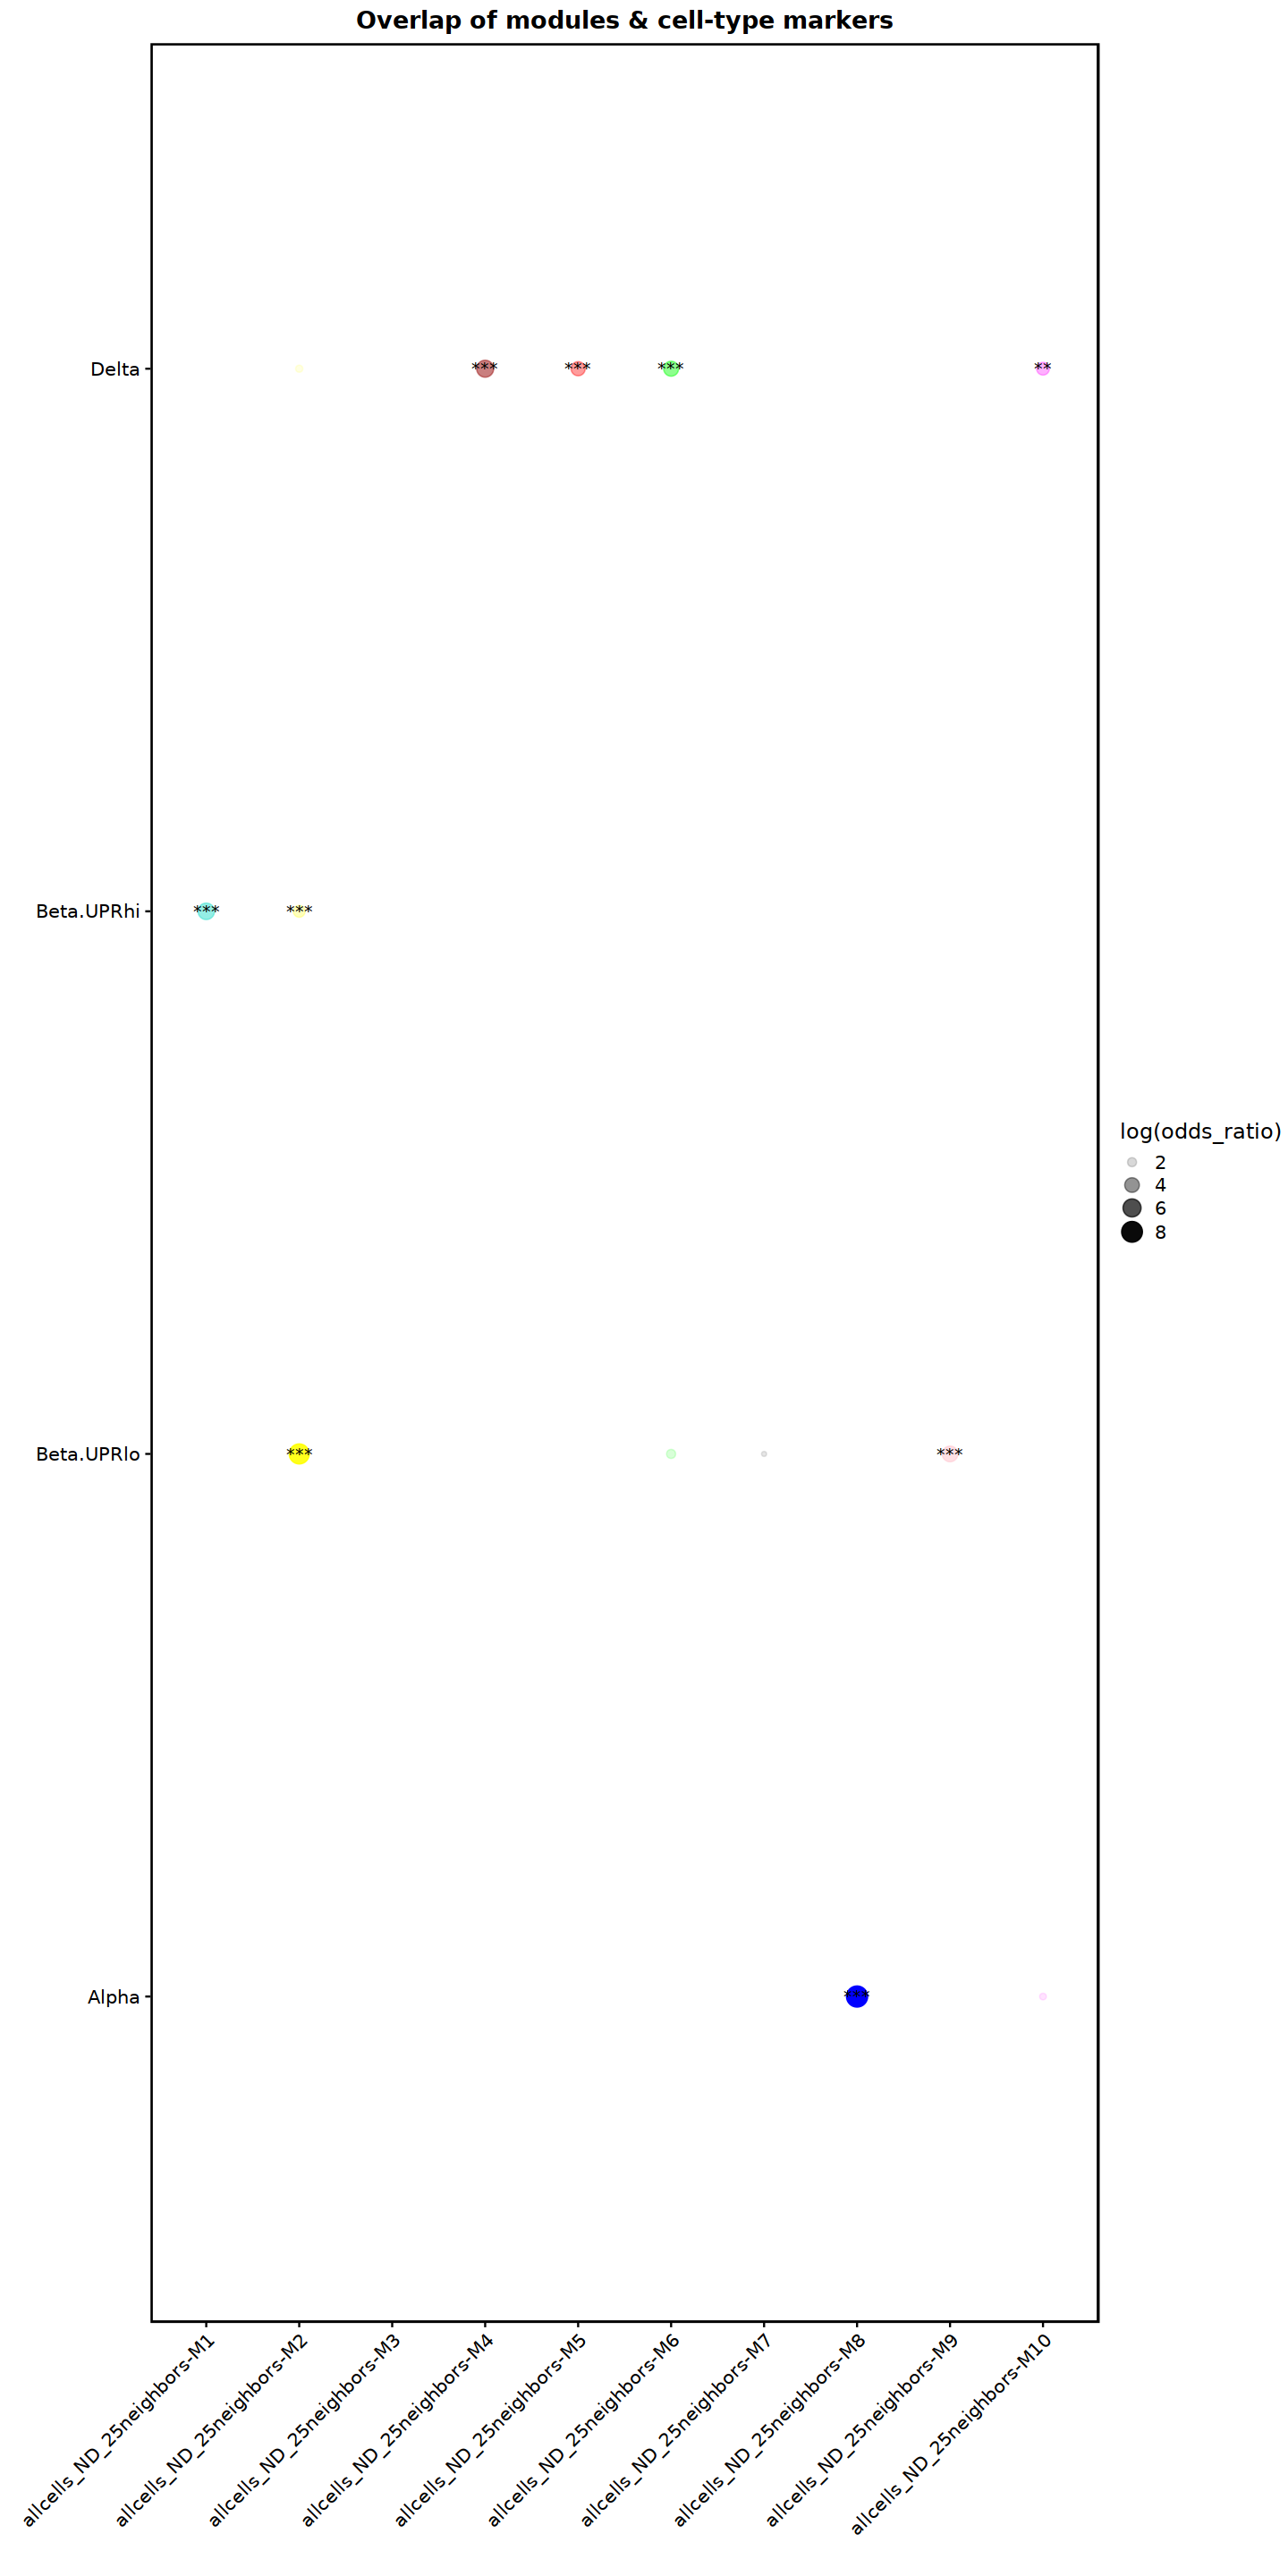

In [34]:
# plot odds ratio of the overlap as a dot plot
OverlapDotPlot(
  overlap_df,
  plot_var = 'odds_ratio') +
  ggtitle('Overlap of modules & cell-type markers')

---

# Scratch